In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import os
import geopandas as gpd
import contextily as ctx
from dataclasses import dataclass
import numpy as np
from scipy.integrate import odeint 

data = 'data/processed/cleaned_data.csv'
SHAPEFILE_PATH = 'data/processed/shapefile/shapefile.shp'

pd.read_csv(data)




,Zip Code,Number of Households,Number of Families,Number of Families with Children,Number of Families with NO Children,Families with no Earners,Percent Distribution of Families,Percent Distribution of Families with Children,Percent Distribution of Families with NO Children,Median Income of all Households,Median Income of all Families
0,10001,14273,4256,1543,2713,329,4256,36.3,63.7,101409,142042.0
1,10002,34737,16914,4650,12264,5433,16914,27.5,72.5,37093,38815.0
2,10003,25181,6855,2057,4798,786,6855,30.0,70.0,137533,219957.0
3,10004,2113,1062,605,457,37,1062,57.0,43.0,216017,247237.0
4,10005,4782,1311,635,676,0,1311,48.4,51.6,197188,250000.0
...,...,...,...,...,...,...,...,...,...,...,...
256,11691,21572,14536,7241,7295,1743,14536,49.8,50.2,54877,74388.0
257,11692,8035,5376,2499,2877,750,5376,46.5,53.5,53498,65045.0
258,11693,5257,3471,1293,2178,820,3471,37.3,62.7,64688,72528.0
259,11694,8392,5047,1821,3226,860,5047,36.1,63.9,88643,117583.0


Accuracy: 0.7555555555555555
ROC AUC Score: 0.0


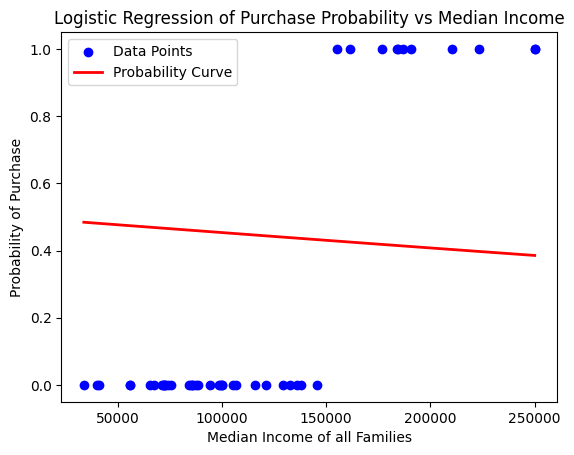

In [28]:
data = pd.read_csv(data)
data['Median Income of all Families'] = data['Median Income of all Families'].astype(str)

# Handle the special case where income is represented as '250,000+'
data['Median Income of all Families'] = data['Median Income of all Families'].replace('250,000+', '250000')

# Convert the column to numeric, coercing errors to NaN
data['Median Income of all Families'] = pd.to_numeric(data['Median Income of all Families'], errors='coerce')

# Assume an arbitrary income threshold to simulate purchase likelihood
income_threshold = 150000  # Adjust this threshold based on your understanding of the data
data['Purchase_Likelihood'] = (data['Median Income of all Families'] > income_threshold).astype(int)

# Handle missing values by dropping them
data.dropna(subset=['Median Income of all Families'], inplace=True)

# Prepare the data for training
X = data[['Median Income of all Families']].values.reshape(-1, 1)
y = data['Purchase_Likelihood']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the trained logistic regression model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # AUC score is a good performance metric for binary classifiers

# Print out the model evaluation results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")

# Plot the results of the logistic regression
# Sort the values to ensure a continuous line plot for probabilities
sorted_indices = X_test.argsort(axis=0).flatten()
X_test_sorted = X_test[sorted_indices]
y_pred_proba_sorted = y_pred_proba[sorted_indices]

plt.scatter(X_test, y_test, color='blue', label='Data Points')
plt.plot(X_test_sorted, y_pred_proba_sorted, color='red', linewidth=2, label='Probability Curve')
plt.xlabel('Median Income of all Families')
plt.ylabel('Probability of Purchase')
plt.title('Logistic Regression of Purchase Probability vs Median Income')
plt.legend()
plt.show()

#

In [31]:
import geopandas as gpd
SHAPEFILE_PATH = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/raw/Modified Zip Code Tabulation Areas (MODZCTA)/geo_export_152003af-efec-4038-9b6f-1963116a24c2.shp'
gdf = gpd.read_file(SHAPEFILE_PATH)

gdf['zcta'] = gdf['zcta'].astype(str)
data['Zip Code'] = data['Zip Code'].astype(str)
merged = gdf.merge(data, left_on='zcta', right_on='Zip Code')
merged['Median Income of all Families'] = pd.to_numeric(merged['Median Income of all Families'], errors='coerce')
merged['Median Income of all Families'].fillna(merged['Median Income of all Families'].median(), inplace=True)
merged['Income Level'] = pd.cut(merged['Median Income of all Families'], bins=4, labels=["Low", "Medium", "High", "Very high"])

# Plot the merged data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column='Income Level', ax=ax, legend=True, cmap='Reds', categorical=True)
leg = ax.get_legend()
leg.set_title('Income Levels')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=merged.crs.to_string())
ax.set_axis_off()
plt.title('Heatmap of Median Family Income by Zip Code')
plt.show()

DriverError: data/processed/shapefile/shapefile.shp: No such file or directory